In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import numpy as np #    
import matplotlib
import tkinter

import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
from IPython.display import display

import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

import pydicom
from skimage.transform import rotate
from skimage.transform import resize
from skimage import exposure
import tifffile

<h1 style="color:red;">NN_700/15(2) - норма (.tiff)</h1>

<h2 style="color:Navy;">1. Создание трехмерноо массива 'volume152' с проверками и преобразованиями при необходимости</h2>

Проверка наличия атрибута ImagePositionPatient перед его использованием.
Использование альтернативных атрибутов: Если ImagePositionPatient отсутствует, упорядочить файлы на основе других атрибутов, таких как InstanceNumber или SliceLocation

In [6]:
directory = 'D:/AleksandrovTI/NN_700/15(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume152 = np.stack([s[0] for s in slices], axis=-1)
print(volume152.shape)

(512, 512, 974)


<h2 style="color:Navy;">2. Визуализация по стандартным проекцим</h2>

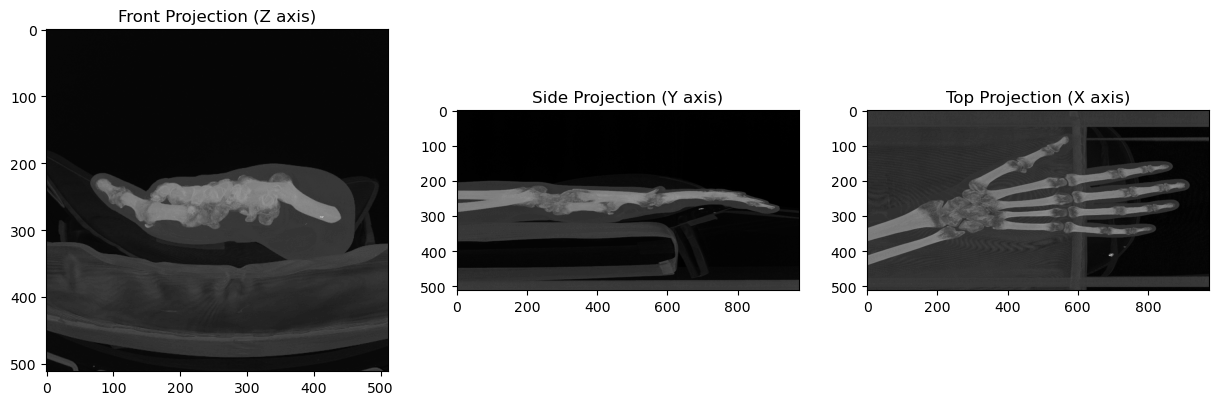

In [7]:
projection_z152 = np.max(volume152, axis=2) # Front projection (по оси Z)
projection_y152 = np.max(volume152, axis=1) # Side projection (по оси Y)
projection_x152 = np.max(volume152, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z152, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y152, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x152, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">3. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ  X</h2>

<h4 style="color:Blue;">3.1 Сохранение массива в TIFF-файл Top projection (по оси X)</h4>

In [8]:
# Top projection (по оси X)
projection_x152 = np.max(volume152, axis=0)
tifffile.imwrite('01_projection_x152.tiff', projection_x152) # Сохранение массива в TIFF-файл

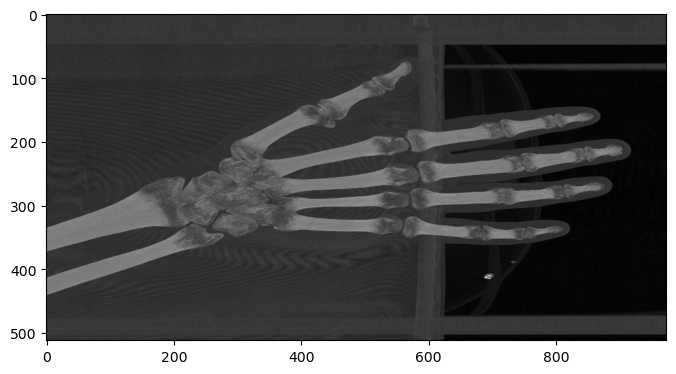

In [9]:
# Отображение изображения
image = tifffile.imread('01_projection_x152.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Blue;">3.2 Построение угла</h4>

In [10]:
# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return image
# Чтение изображения
image = cv2.imread('01_projection_x152.tiff')
# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=50, contrast=500)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
a = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)
            angles.append(angle)
           

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('02_projection_x152_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')

Угол между линией №1 и горизонтом: 15.98 градусов
Горизонтальная линия нарисована через точку: (941, 86)
Углы, сохраненные в программе: [15.984801520234573]


In [11]:
print(angle)

15.984801520234573


In [12]:
a1 = angle
a1

15.984801520234573

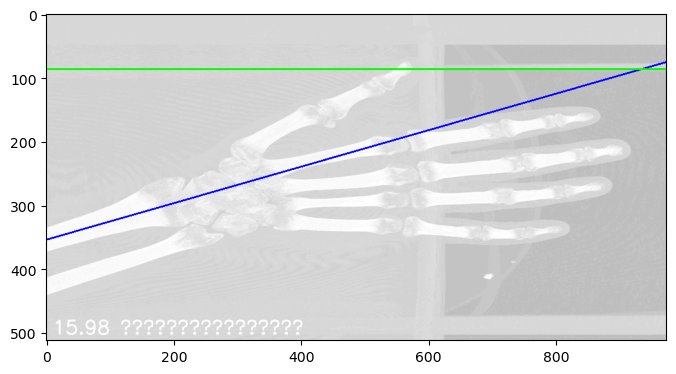

In [13]:
# Отображение изображения
image1 = tifffile.imread('02_projection_x152_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">4. Поворот плоскостей вокруг оси Z с заданным углом поворота - получение  'rotated_volume152'</h2>

Original volume shape: (512, 512, 974)
Rotated volume shape: (512, 512, 974)


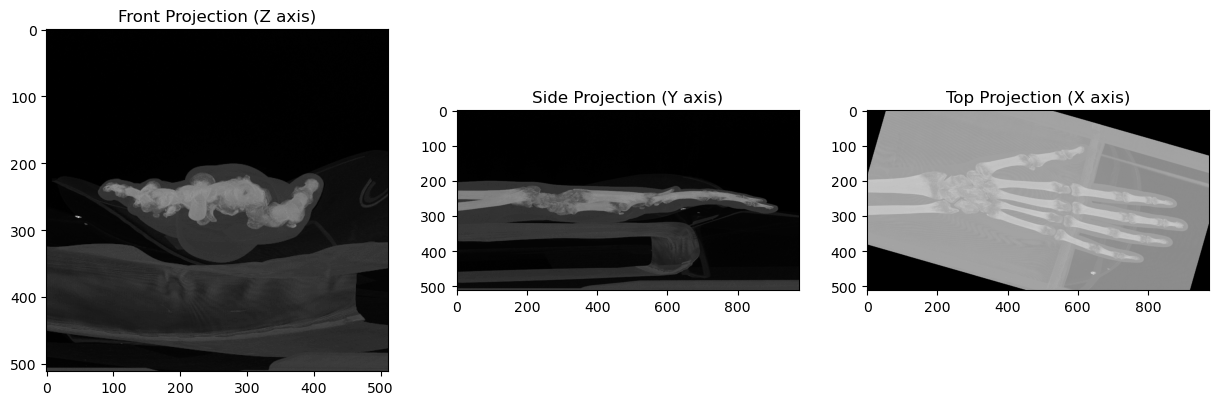

In [14]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI/NN_700/15(2)'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота 
angle = a1

# Поворот объёма вокруг оси Z
rotated_volume152 = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume152.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume152)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h2 style="color:Navy;">5. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ Y</h2>

<h4 style="color:Blue;">5.1 Сохранение массива в TIFF-файл Side Projection (Y axis)</h4>

In [15]:
# Side Projection (Y axis)
projection_yr152 = np.max(rotated_volume152, axis=1)
projection_yr152 = np.flip(projection_yr152, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr152.tiff', projection_yr152)

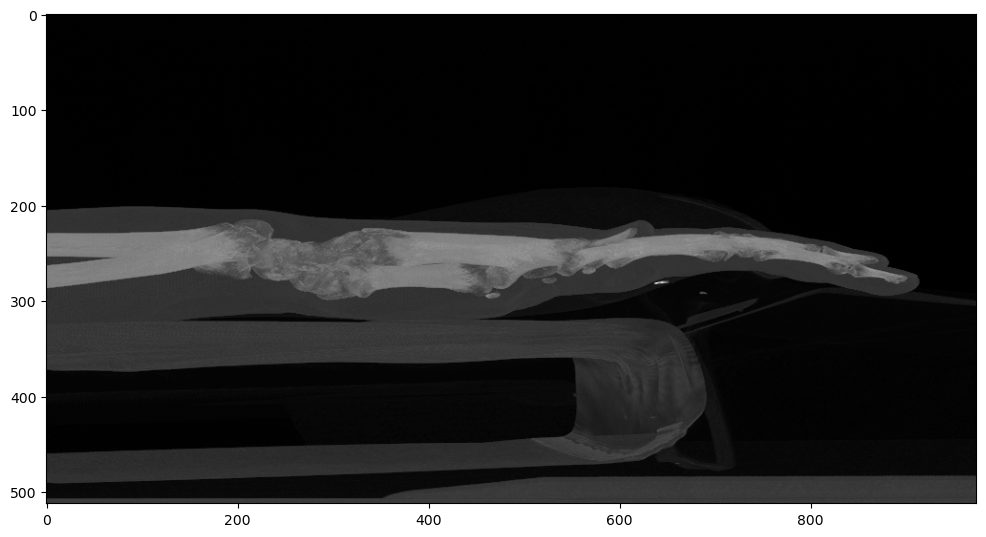

In [16]:
# Отображение изображения
image = tifffile.imread('03_projection_yr152.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Blue;">5.2 Построение угла</h4>

In [17]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)
            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr152_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')

Угол между линией №1 и горизонтом: 2.13 градусов
Горизонтальная линия нарисована через точку: (957, 277)
Углы, сохраненные в программе: [2.132368436554014]


In [18]:
angle

2.132368436554014

In [19]:
b1 = angle
b1

2.132368436554014

In [20]:
a1

15.984801520234573

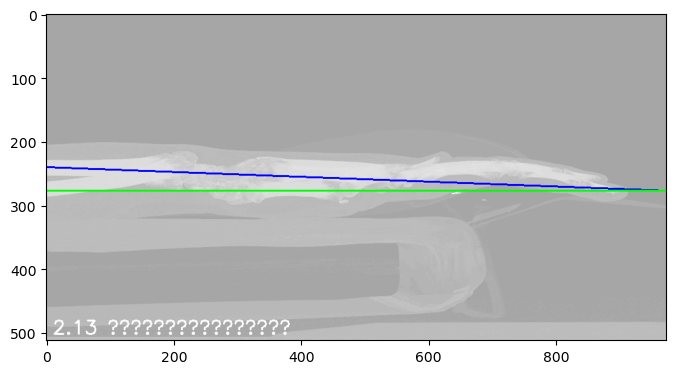

In [21]:
# Отображение изображения
image1 = tifffile.imread('04_projection_yr152_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">6. Поворот плоскостей вокруг оси Y с заданным углом поворота - получение  'twice_rotated_volume152'</h2>

Rotated volume shape: (512, 512, 974)


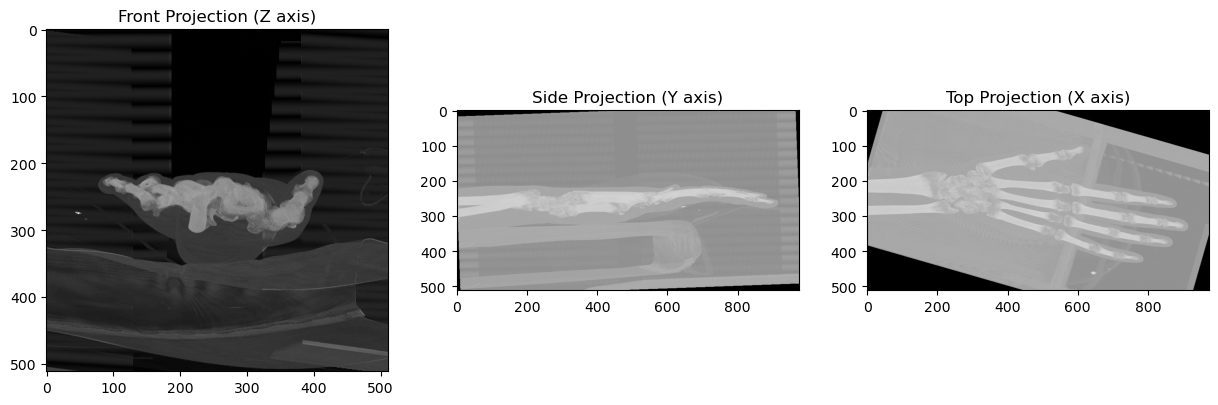

In [22]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = - b1

# Поворот объёма вокруг оси Y
twice_rotated_volume152 = rotate_volume(rotated_volume152, angle)
print("Rotated volume shape:", twice_rotated_volume152.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume152)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h2 style="color:Navy;">7. Определение плотности кости по пикселям массива</h2>

<h4 style="color:Navy;">7.1 Вывод проекции Х в twice_rotated_volume152 для определения координаты СРЕДИННОГО сечения искомого массива</h4>

In [23]:
# Top projection (по оси X)
projection_xrr152 = np.max(twice_rotated_volume152, axis=0)
projection_xrr152 = np.flip(projection_xrr152, axis=1)
tifffile.imwrite('05_projection_xrr152.tiff', projection_xrr152)

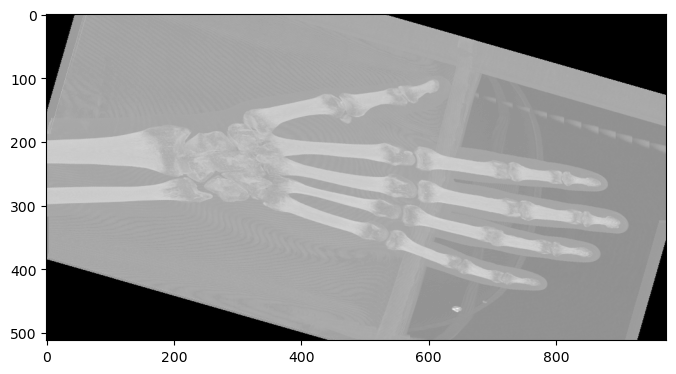

In [24]:
# Отображение изображения
image = tifffile.imread('05_projection_xrr152.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.2 Определениt координаты СРЕДИННОГО сечения искомого массива</h4>

In [25]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection_xrr152.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (179, 213)


<h4 style="color:Navy;">7.3 Изображение с ценой деления 10 для уточнения размера интервала третьего измерения искомого массива</h4>

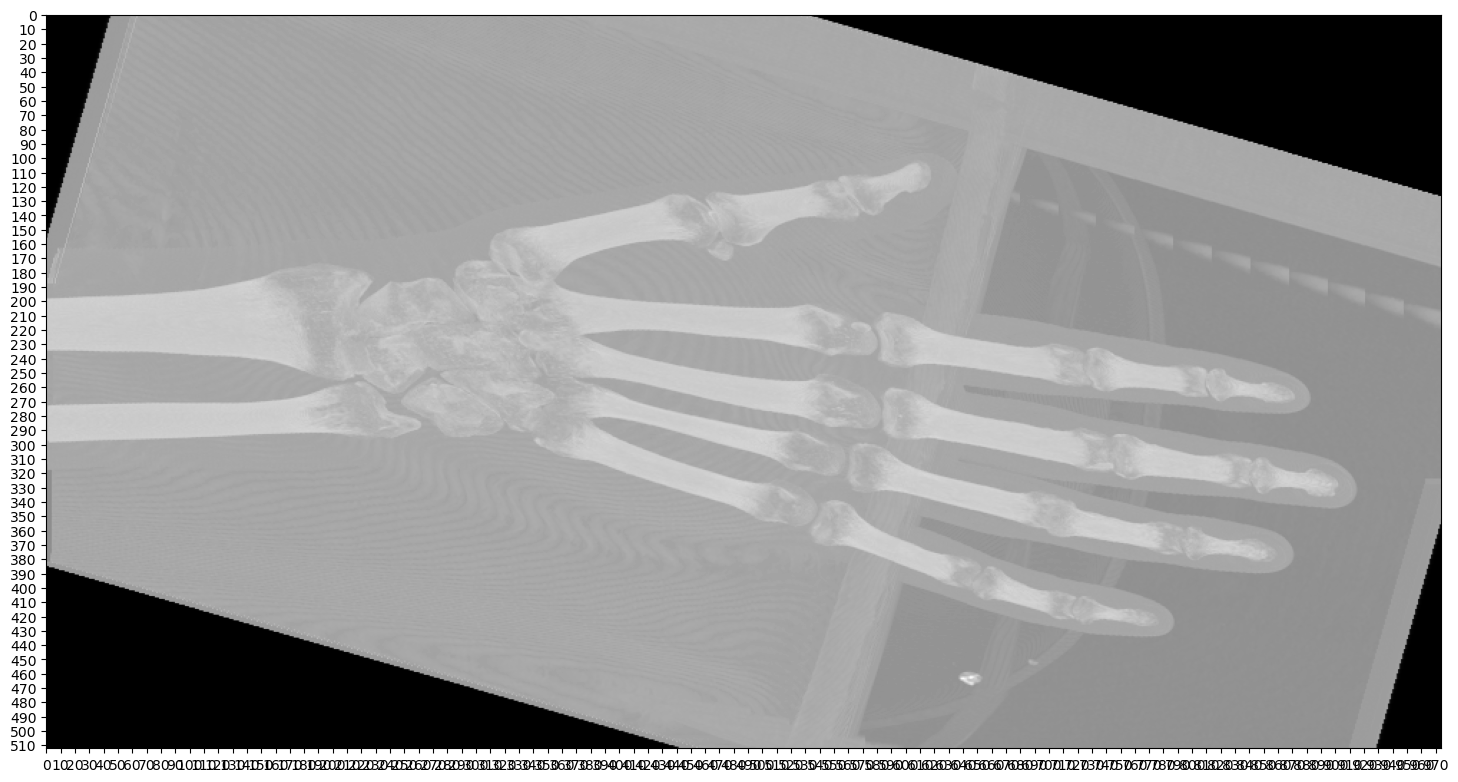

In [26]:
gray_image = mpimg.imread('05_projection_xrr152.tiff')

# Создание фигуры и осей
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(18, 12))  # Увеличенный размер холста
# Отображение изображения
ax.imshow(gray_image, cmap='gray', extent=[0, gray_image.shape[1], gray_image.shape[0], 0])

# Настройка тиков по осям x и y с шагом 20
ax.set_xticks(np.arange(0, gray_image.shape[1], 10))
ax.set_yticks(np.arange(0, gray_image.shape[0], 10))

# Показ графика
plt.show()

<h4 style="color:Navy;">7.4 Транспонирование twice_rotated_volume152 в нужную форму для получения искомых массива сечений</h4>

In [27]:
vol = np.transpose(twice_rotated_volume152, (1, 2, 0))
vol.shape

(512, 974, 512)

<h2 style="color:Navy;">MONO</h2>

In [28]:
pictmono = vol[213]
# Зеркальное отражение изображения слева направо
pictmono.shape

(974, 512)

In [29]:
pictmono1 = np.transpose(pictmono, (1, 0))
flipped_mono = np.flip(pictmono1, axis=1)
print(f"Исходный массив: {pictmono.shape}")
print(f"Преобразованный массив: {flipped_mono.shape}")

Исходный массив: (974, 512)
Преобразованный массив: (512, 974)


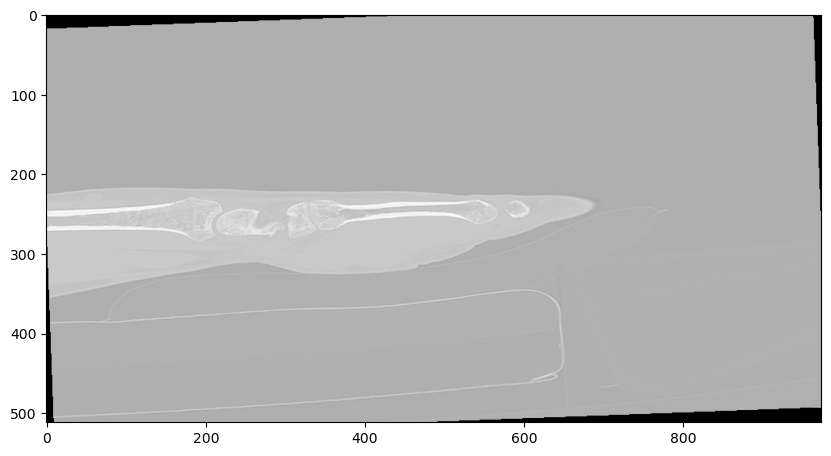

In [30]:
# Сохранение массива в TIFF-файл
tifffile.imwrite('06_from_pictMONO_xrr152.tiff', flipped_mono)
# Отображение изображения
image = tifffile.imread('06_from_pictMONO_xrr152.tiff')
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.5 Обрезка изображения по краям (на 30 пикселей) для быстрого получения контрастного изображения</h4>

In [31]:
image = Image.open('06_from_pictMONO_xrr152.tiff')

# размеры для обрезки
left = 25
top = 25
right = 25
bottom = 25

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('07_cropped_from_pictMONO_xrr152.tiff')

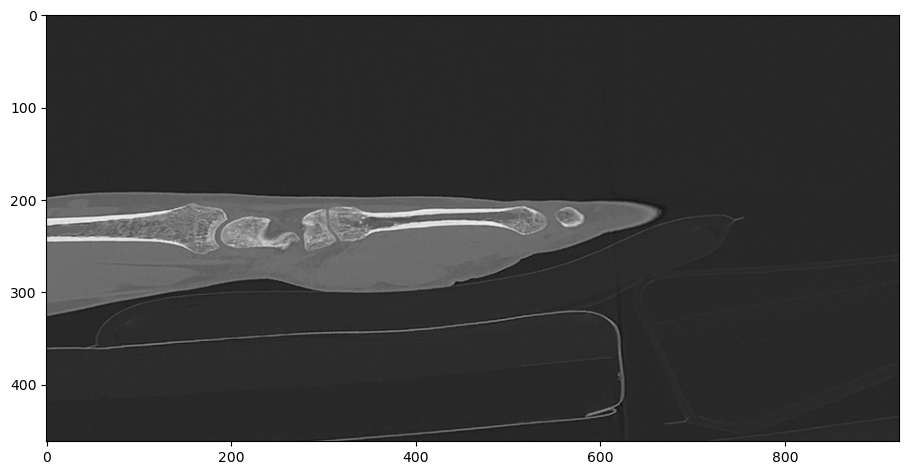

In [32]:
image = tifffile.imread('07_cropped_from_pictMONO_xrr152.tiff')
plt.figure(figsize=(11, 11))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.6 Вырезка прямоугольного (универсального) изображения</h4>

In [33]:
matplotlib.use('TkAgg')  # Используйте TkAgg backend
plt.figure(figsize=(15, 15))

                
def crop_image(image, coords):
    cropped_image = image.crop(coords)
    return cropped_image

def get_coords(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    coords = plt.ginput(4)
    plt.close()
    return coords

image_path = '07_cropped_from_pictMONO_xrr152.tiff'
image = tifffile.imread(image_path)
#enhancer = ImageEnhance.Contrast(image) # Создание объекта для улучшения контрастности
#enhanced_image = enhancer.enhance(1.0) # Увеличение контрастности в 2 раза
coords = get_coords(image_path)

x_coordinates = sorted([int(coord[0]) for coord in coords])
y_coordinates = sorted([int(coord[1]) for coord in coords])
    
x1, y1 = x_coordinates[0], y_coordinates[0]
x2, y2 = x_coordinates[3], y_coordinates[3]
        
plt.figure(figsize=(20, 20))
image = Image.open(image_path)
cropped_image = crop_image(image, (x1, y1, x2, y2))
               
#output_path = os.path.join(output_folder, file_name)
cropped_image.save('08_rectangle_MONO_xrr152.tiff')

In [34]:
image = Image.open('08_rectangle_MONO_xrr152.tiff')
imageq = np.array(image)
# размеры для обрезки
left = imageq.shape[1] - 100
top = 0
right = 0
bottom = 0
cropped_image = image.crop((left, top, image.width - right, image.height - bottom))
cropped_image.save('09_rectangle_MONO_xrr152_finish.tiff')

<Figure size 2000x2000 with 0 Axes>

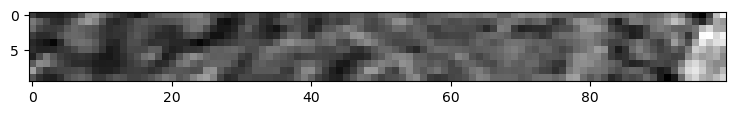

In [35]:
%matplotlib inline
image = tifffile.imread('09_rectangle_MONO_xrr152_finish.tiff')
plt.figure(figsize=(9, 9))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

In [36]:
# Загрузка изображения в градациях серого
image = cv2.imread('09_rectangle_MONO_xrr152_finish.tiff', cv2.IMREAD_GRAYSCALE)

# Пример весов (например, можно задать каждому пикселю одинаковый вес)
height, width = image.shape
weights = np.ones((height, width))

# Обратим внимание: изображение и веса должны быть выровнены линейно
linear_image = image.flatten()
linear_weights = weights.flatten()

# Вычисление средневзвешенного значения всех пикселей
weighted_mean2 = np.average(linear_image, weights=linear_weights)

print(f'Средневзвешенное значение всех пикселей: {weighted_mean2}')

Средневзвешенное значение всех пикселей: 32.101


<h4 style="color:SeaGreen;">MONO = 32.101</h4>

<h2 style="color:Navy;">"STEREO"</h2>

<h4 style="color:Navy;">7.7 Выбранный размер ОБЪЁМНОГО массива сечений кости</h4>

In [38]:
pict = vol[203:223]
pict.shape

(20, 974, 512)

<h4 style="color:Navy;">7.8 Преобразование массива к размерности (974, 512, 20) в соответствии с размерностью изображения</h4>

In [39]:
# Преобразование массива к размерности (974, 512, 20)
pict_20channels = np.transpose(pict, (2, 1, 0))

print(f"Исходный массив: {pict.shape}")
print(f"Преобразованный массив: {pict_20channels.shape}")

Исходный массив: (20, 974, 512)
Преобразованный массив: (512, 974, 20)


<h4 style="color:Navy;">7.9 Преобразование 20-канального "изображения" к 1-канальному</h4>

In [40]:
# Преобразование массива в (512, 974, 1)
pict_averaged = np.mean(pict_20channels, axis=2, keepdims=True)# axis=2 == среднее по третьей оси, keepdims=True сохраняет третью ось с размерностью 1 
# Зеркальное отражение изображения слева направо
flipped_image = np.flip(pict_averaged, axis=1)
flipped_image.shape

(512, 974, 1)

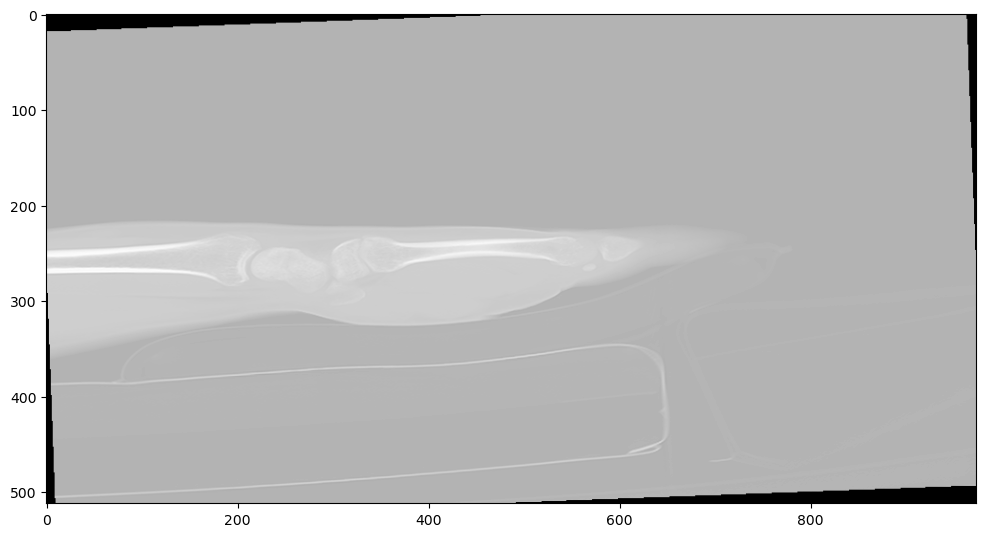

In [41]:
# Сохранение массива в TIFF-файл
tifffile.imwrite('10_from_vol_20_1_xrr152.tiff', flipped_image)
# Отображение изображения
image = tifffile.imread('10_from_vol_20_1_xrr152.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.10 Преобразование одноканального трёхмерного изображения в двумерное</h4>

In [42]:
image = tifffile.imread('10_from_vol_20_1_xrr152.tiff')

image_array = np.array(image) # Преобразование в массив numpy (если нужно)
if image_array.ndim == 3 and image_array.shape[2] == 1: # Убедиться, что это одноканальное изображение
    gray_image = image_array[:, :, 0]  # Удаление последнего измерения

    # Преобразование обратно в изображение
    result_image = Image.fromarray(gray_image.astype(np.uint16))
    result_image.save('11_one_chan_from_vol_20_1_xrr152.tiff')

In [43]:
print(gray_image.shape)
print(gray_image.min())
print(gray_image.max())

(512, 974)
0.0
10230.8


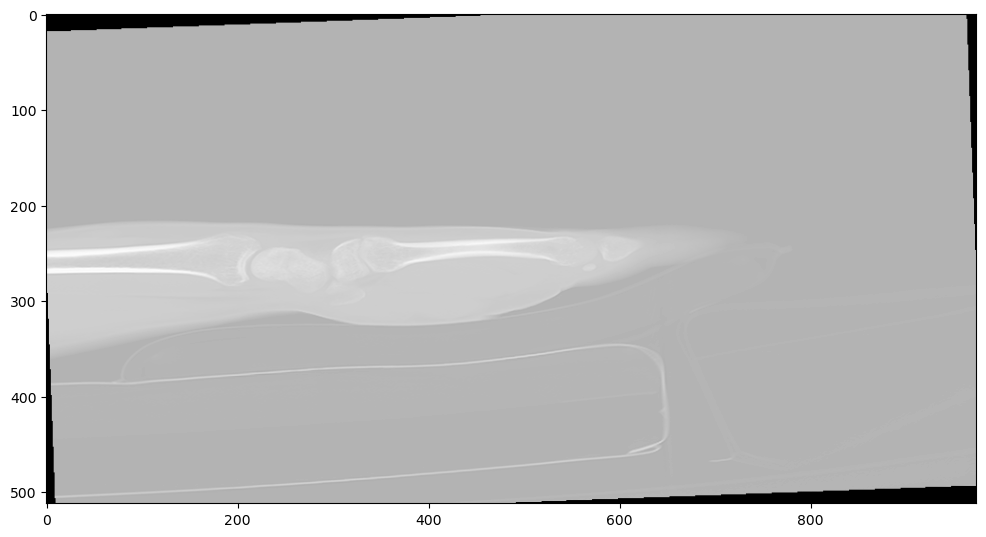

In [44]:
image = tifffile.imread('11_one_chan_from_vol_20_1_xrr152.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.11 Обрезка изображения по краям (на 25 пикселей) для быстрого получения контрастного изображения</h4>

In [45]:
image = Image.open('11_one_chan_from_vol_20_1_xrr152.tiff')

# размеры для обрезки
left = 25
top = 25
right = 25
bottom = 25

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('12_cropped_one_chan_from_vol_20_1_xrr152.tiff')

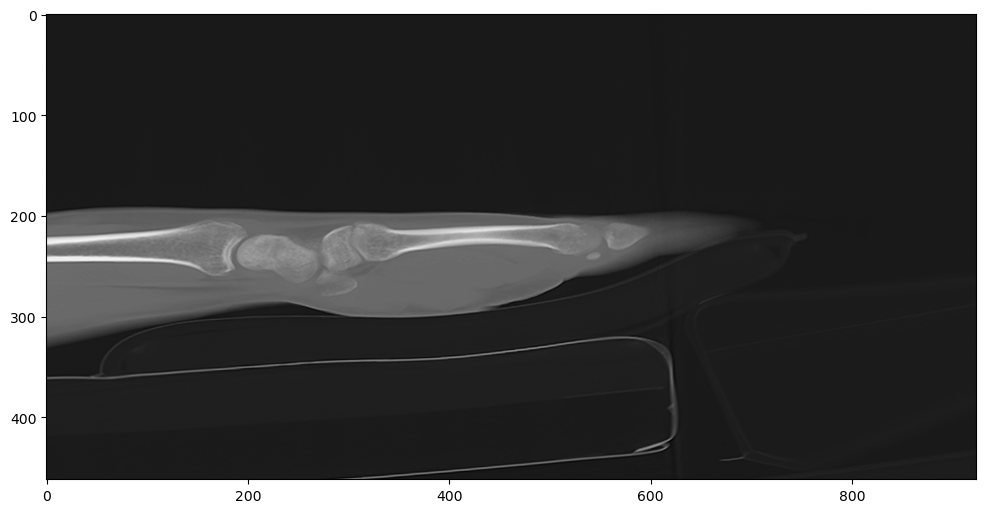

In [46]:
image = tifffile.imread('12_cropped_one_chan_from_vol_20_1_xrr152.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">8.2 Вырезка прямоугольного изображения</h4>

In [47]:
matplotlib.use('TkAgg')  # Используйте TkAgg backend
plt.figure(figsize=(15, 15))

                
def crop_image(image, coords):
    cropped_image = image.crop(coords)
    return cropped_image

def get_coords(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    coords = plt.ginput(4)
    plt.close()
    return coords

image_path = '12_cropped_one_chan_from_vol_20_1_xrr152.tiff'
image = tifffile.imread(image_path)
#enhancer = ImageEnhance.Contrast(image) # Создание объекта для улучшения контрастности
#enhanced_image = enhancer.enhance(1.0) # Увеличение контрастности в 2 раза
coords = get_coords(image_path)

x_coordinates = sorted([int(coord[0]) for coord in coords])
y_coordinates = sorted([int(coord[1]) for coord in coords])
    
x1, y1 = x_coordinates[0], y_coordinates[0]
x2, y2 = x_coordinates[3], y_coordinates[3]
        
plt.figure(figsize=(20, 20))
image = Image.open(image_path)
cropped_image = crop_image(image, (x1, y1, x2, y2))
               
#output_path = os.path.join(output_folder, file_name)
cropped_image.save('13_vol_20_1_xrr152_finish.tiff')

<Figure size 2000x2000 with 0 Axes>

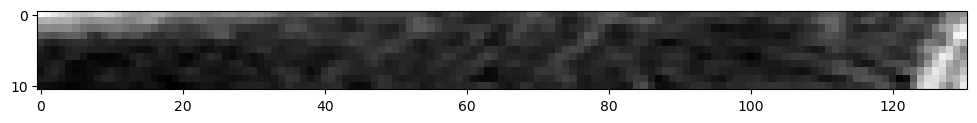

In [48]:
%matplotlib inline
image = tifffile.imread('13_vol_20_1_xrr152_finish.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">8.3 Обрезка в размер (100 пикселей) для корректности сравнения различных образцов</h4>

In [49]:
image = Image.open('13_vol_20_1_xrr152_finish.tiff')
imageqq = np.array(image)
# размеры для обрезки
left = imageqq.shape[1] - 100
top = 0
right = 0
bottom = 0
cropped_imageqq = image.crop((left, top, image.width - right, image.height - bottom))
cropped_imageqq.save('14_vol_20_1_xrr152_ready.tiff')

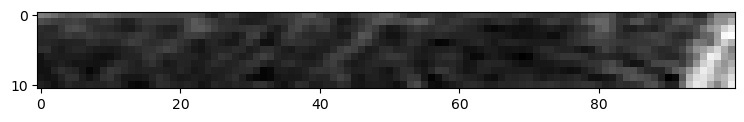

In [50]:
%matplotlib inline
image = tifffile.imread('14_vol_20_1_xrr152_ready.tiff')
plt.figure(figsize=(9, 9))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">8.3 Определение плотности по средневзвешеному значению среднеобъёмных пикселей</h4>

In [51]:
# Загрузка изображения в градациях серого
image = cv2.imread('14_vol_20_1_xrr152_ready.tiff', cv2.IMREAD_GRAYSCALE)

# Пример весов (например, можно задать каждому пикселю одинаковый вес)
height, width = image.shape
weights = np.ones((height, width))

# Обратим внимание: изображение и веса должны быть выровнены линейно
linear_image = image.flatten()
linear_weights = weights.flatten()

# Вычисление средневзвешенного значения всех пикселей
weighted_mean1 = np.average(linear_image, weights=linear_weights)

print(f'Средневзвешенное значение всех пикселей: {weighted_mean1}')

Средневзвешенное значение всех пикселей: 32.24727272727273


In [52]:
# Загрузка изображения в градациях серого
image = cv2.imread('09_rectangle_MONO_xrr152_finish.tiff', cv2.IMREAD_GRAYSCALE)

# Пример весов (например, можно задать каждому пикселю одинаковый вес)
height, width = image.shape
weights = np.ones((height, width))

# Обратим внимание: изображение и веса должны быть выровнены линейно
linear_image = image.flatten()
linear_weights = weights.flatten()

# Вычисление средневзвешенного значения всех пикселей
weighted_mean2 = np.average(linear_image, weights=linear_weights)

print(f'Средневзвешенное значение всех пикселей: {weighted_mean2}')

Средневзвешенное значение всех пикселей: 32.101


In [53]:
(weighted_mean2 - weighted_mean1) / weighted_mean2 *100

-0.45566408296542377

<h3 style="color:Fuchsia;">Отличие в результатах по 20-мернму и 1-мерному пространствам - 0,5% </h3>

<h1 style="color:DarkSlateGray;">9. Раскрытие суставных щелей</h1>

<h4 style="color:DarkSlateGray;">9.1 Ветикальное сечение проекции "projection_yrr" Side Projection (Y axis)</h4>

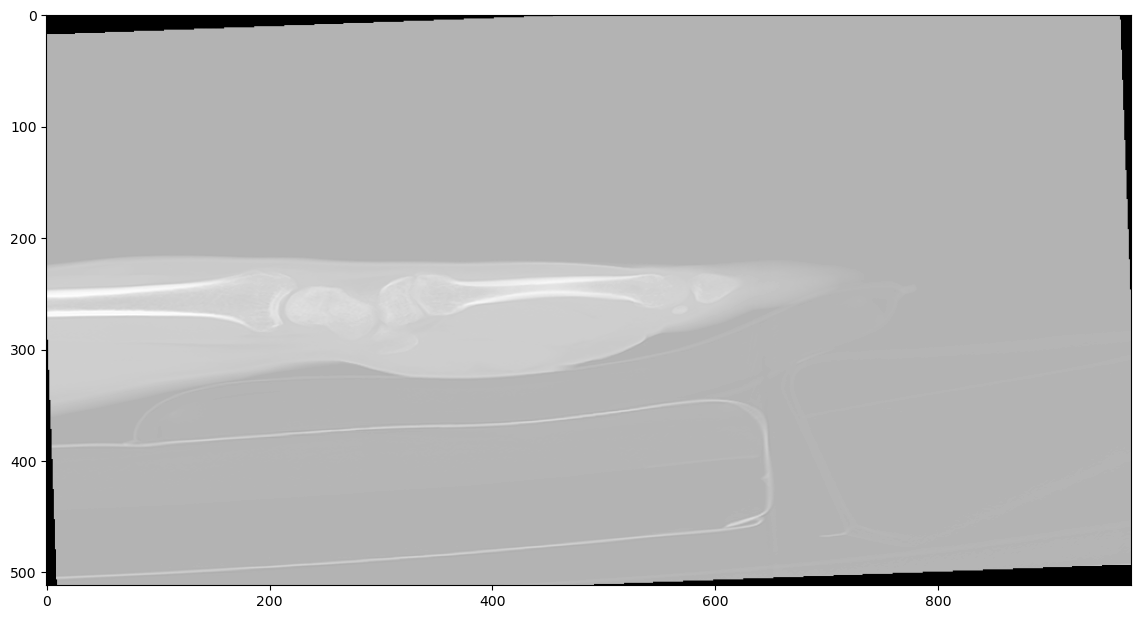

In [54]:
image = tifffile.imread('11_one_chan_from_vol_20_1_xrr152.tiff')
plt.figure(figsize=(14, 14))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:DarkSlateGray;">9.2 Определение на вертикальном сечении проекции "projection_yrr" Side Projection координату последующего сечения Z плоскостью</h4>

In [55]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('11_one_chan_from_vol_20_1_xrr152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (199, 264)


<h4 style="color:DarkSlateGray;">9.3 Сечение массива второго поворота "twice_rotated_volume152" плоскостью на высоте 264</h4>

In [57]:
twice_rotated_volume152.shape

(512, 512, 974)

In [70]:
pictt1 = twice_rotated_volume152[258]
# Зеркальное отражение изображения слева направо
#flipped_pictt1 = np.flip(pictt1, axis=1)
flipped_pictt11 = np.transpose(pictt1, (1, 0))

In [71]:
pictt2 = twice_rotated_volume152[261]
# Зеркальное отражение изображения слева направо
#flipped_pictt2 = np.flip(pictt2, axis=1)
flipped_pictt22 = np.transpose(pictt2, (1, 0))

In [72]:
pictt3 = twice_rotated_volume152[264]
# Зеркальное отражение изображения слева направо
#flipped_pictt3 = np.flip(pictt3, axis=1)
flipped_pictt33 = np.transpose(pictt3, (1, 0))

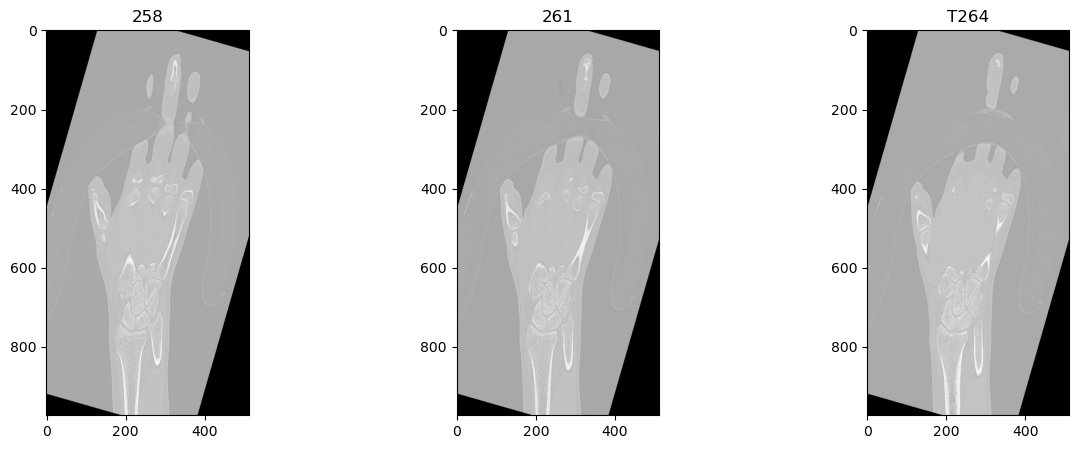

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt11, cmap='gray')
axs[0].set_title('258')

axs[1].imshow(flipped_pictt22, cmap='gray')
axs[1].set_title('261')

axs[2].imshow(flipped_pictt33, cmap='gray')
axs[2].set_title('T264')

plt.show()

<h4 style="color:DarkSlateGray;">9.4 Обрезка изображения для черно-белого изображения</h4>

In [75]:
tifffile.imwrite('15_258_152.tiff', flipped_pictt11) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_261_152.tiff', flipped_pictt22) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_264_152.tiff', flipped_pictt33) # Сохранение массива в TIFF-файл

In [76]:
image = Image.open('15_258_152.tiff')

# размеры для обрезки
left = 75
top = 550
right = 125
bottom = 100

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_258_152_bw.tiff')

#### 258

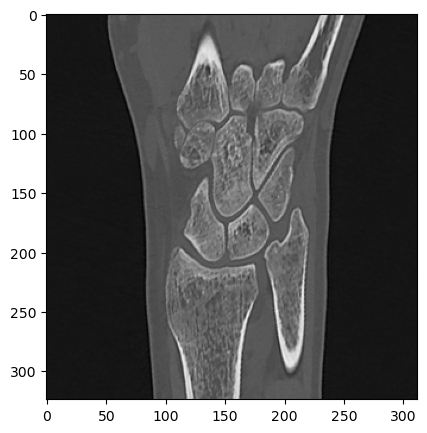

In [84]:
%matplotlib inline
#gray_image152 = mpimg.imread('152_for_line.png')
gray_image152 = Image.open('16_258_152_bw.tiff')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [79]:
image = Image.open('15_261_152.tiff')

# размеры для обрезки
left = 75
top = 550
right = 125
bottom = 100

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_261_152_bw.tiff')

#### 261

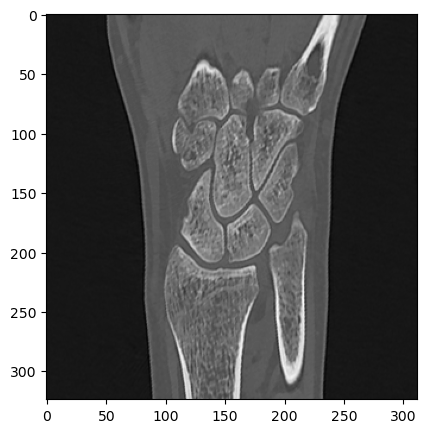

In [83]:
%matplotlib inline
#gray_image152 = mpimg.imread('152_for_line.png')
gray_image152 = Image.open('16_261_152_bw.tiff')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [81]:
image = Image.open('15_264_152.tiff')

# размеры для обрезки
left = 75
top = 550
right = 125
bottom = 100

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_264_152_bw.tiff')

#### 264

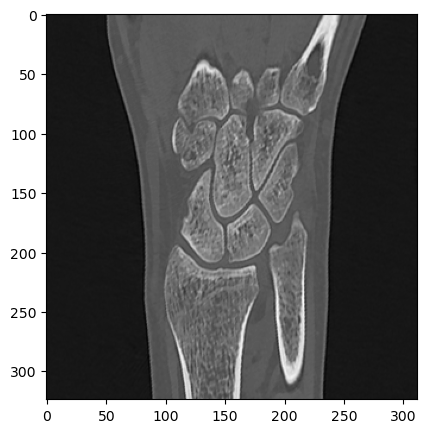

In [82]:
%matplotlib inline
#gray_image152 = mpimg.imread('152_for_line.png')
gray_image152 = Image.open('16_261_152_bw.tiff')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

<h1 style="color:red;">PP_700/54(2) - патология</h1>

<h2 style="color:Navy;">1. Создание трехмерноо массива с проверками и преобразованиями при необходимости</h2>

In [3]:
directory = 'D:/AleksandrovTI//PP_700/54(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume542 = np.stack([s[0] for s in slices], axis=-1)
print(volume542.shape)

(512, 512, 863)


<h2 style="color:Navy;">2. Визуализация по стандартным проекцим</h2>

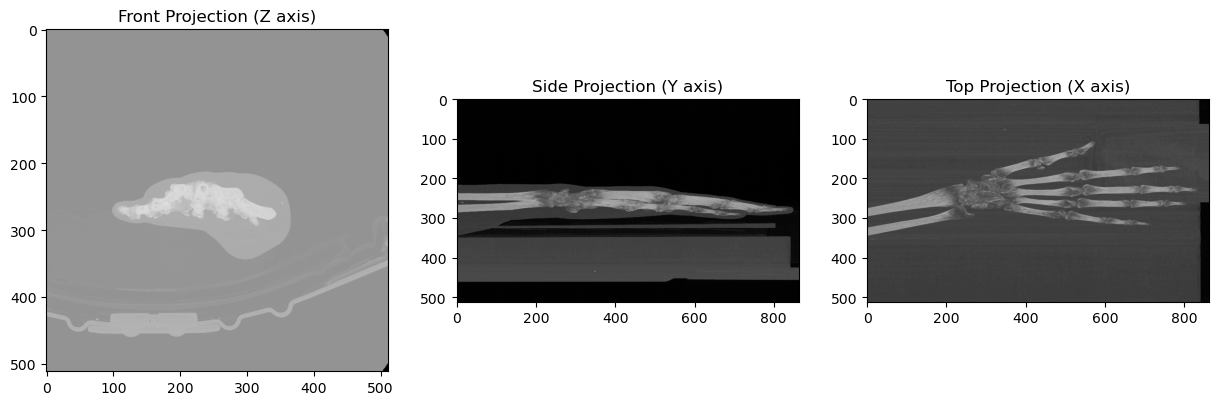

In [4]:
projection_z542 = np.max(volume542, axis=2) # Front projection (по оси Z)
projection_y542 = np.max(volume542, axis=1) # Side projection (по оси Y)
projection_x542 = np.max(volume542, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z542, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y542, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x542, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">3. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ  X</h2>

<h4 style="color:Navy;">3.1 Сохранение массива в TIFF-файл Top projection (по оси X)</h4>

In [5]:
# Top projection (по оси X)
projection_x542 = np.max(volume542, axis=0)
tifffile.imwrite('01_projection_x542.tiff', projection_x542) # Сохранение массива в TIFF-файл

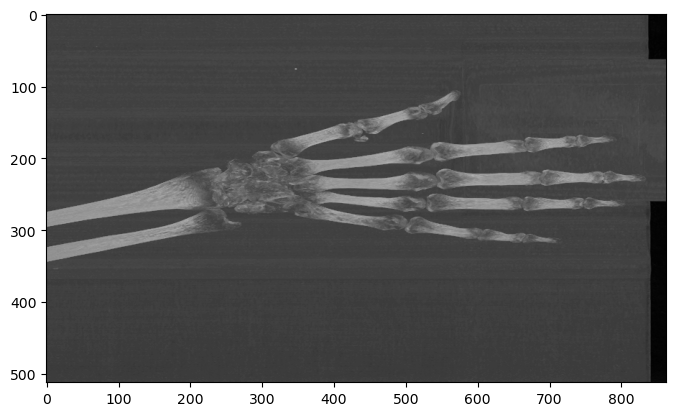

In [6]:
# Отображение изображения
image = tifffile.imread('01_projection_x542.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">3.2 Построение угла</h4>

In [7]:
# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return image
# Чтение изображения
image = cv2.imread('01_projection_x542.tiff')
# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=50, contrast=500)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
a = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)
            angles.append(angle)
           

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('02_projection_x542_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')

Угол между линией №1 и горизонтом: 10.70 градусов
Горизонтальная линия нарисована через точку: (833, 131)
Углы, сохраненные в программе: [10.699343374304165]


In [8]:
print(angle)

10.699343374304165


In [9]:
c1 = angle
c1

10.699343374304165

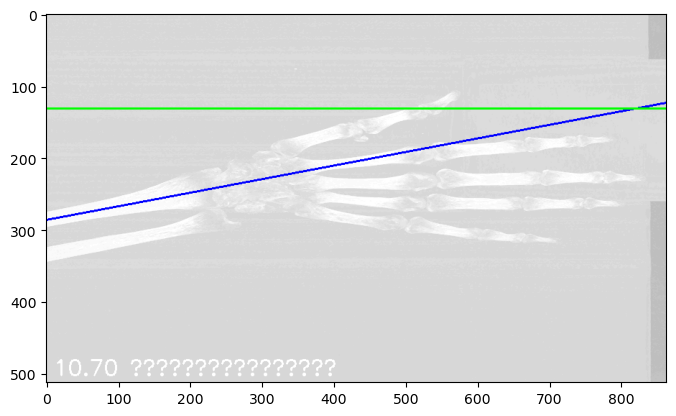

In [10]:
# Отображение изображения
image1 = tifffile.imread('02_projection_x542_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">4. Поворот плоскостей вокруг оси Z с заданным углом поворота - получение  'rotated_volume152'</h2>

Original volume shape: (512, 512, 863)
Rotated volume shape: (512, 512, 863)


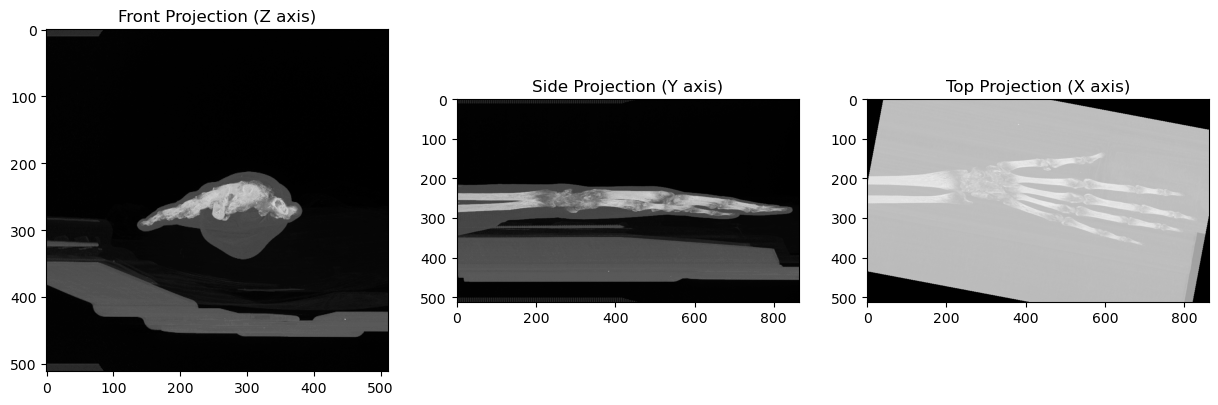

In [11]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI//PP_700/54(2)'

# Чтение и нормализация изображения
volume542 = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume542.shape)

# Угол поворота 
angle = c1

# Поворот объёма вокруг оси Z
rotated_volume542 = rotate_volume(volume542, angle)
print("Rotated volume shape:", rotated_volume542.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume542)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">5. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ Y</h2>

<h4 style="color:Navy;">5.1 Сохранение массива в TIFF-файл Side Projection (Y axis)</h4>

In [12]:
# Side Projection (Y axis)
projection_yr542 = np.max(rotated_volume542, axis=1)
projection_yr542 = np.flip(projection_yr542, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr542.tiff', projection_yr542)

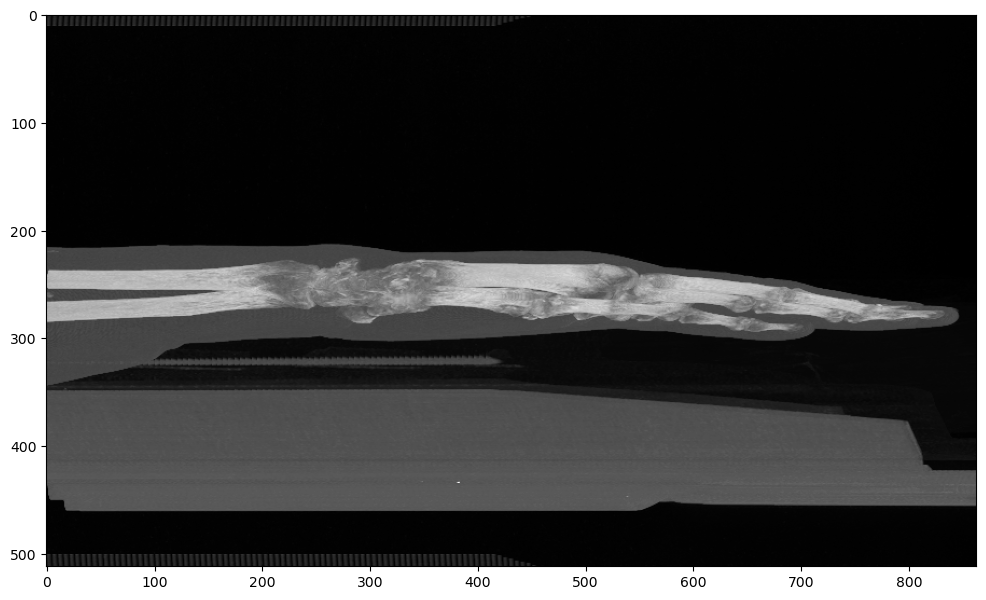

In [13]:
# Отображение изображения
image = tifffile.imread('03_projection_yr542.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">5.2 Построение угла</h4>

In [14]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr542.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)
            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr542_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')

Угол между линией №1 и горизонтом: 1.24 градусов
Горизонтальная линия нарисована через точку: (849, 266)
Углы, сохраненные в программе: [1.23997476631269]


In [15]:
angle

1.23997476631269

In [16]:
d1 = angle
d1

1.23997476631269

In [17]:
c1

10.699343374304165

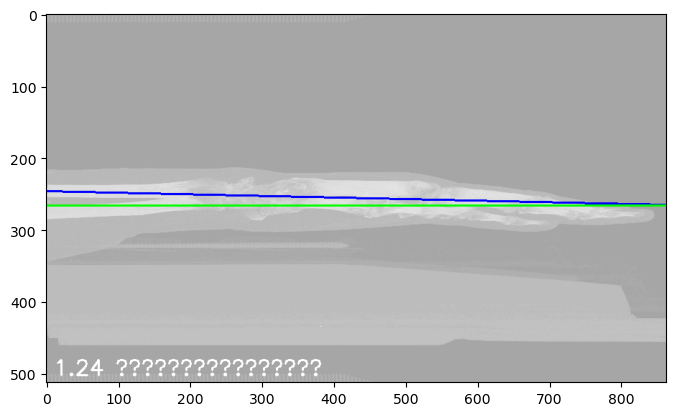

In [18]:
# Отображение изображения
image1 = tifffile.imread('04_projection_yr542_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">6. Поворот плоскостей вокруг оси Y с заданным углом поворота - получение  'twice_rotated_volume152'</h2>

Rotated volume shape: (512, 512, 863)


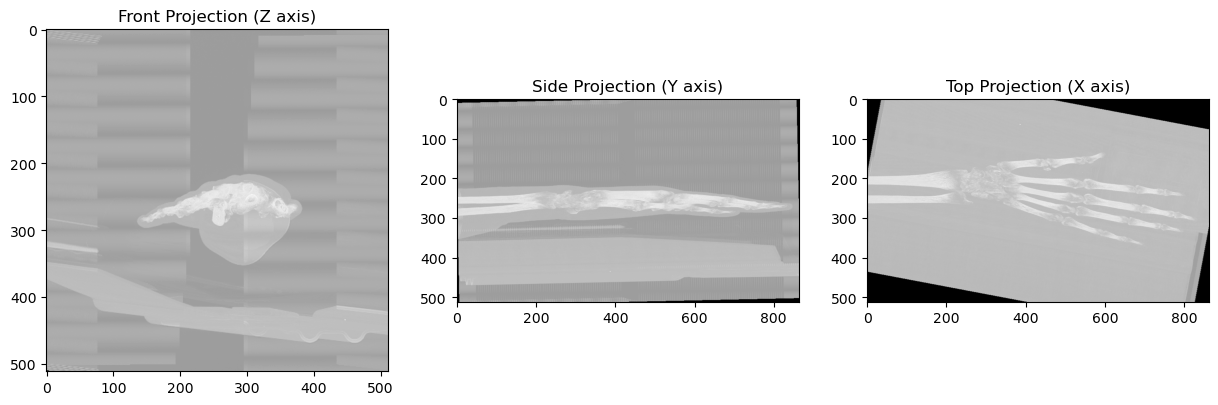

In [19]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = - d1

# Поворот объёма вокруг оси Y
twice_rotated_volume542 = rotate_volume(rotated_volume542, angle)
print("Rotated volume shape:", twice_rotated_volume542.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume542)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">7. Определение плотности кости по пикселям многомерного массива</h2>

<h4 style="color:Navy;">7.1 Вывод проекции Х в twice_rotated_volume152 для определения координаты СРЕДИННОГО сечения искомого массива</h4>

In [20]:
# Top projection (по оси X)
projection_xrr542 = np.max(twice_rotated_volume542, axis=0)
projection_xrr542 = np.flip(projection_xrr542, axis=1)
tifffile.imwrite('05_projection_xrr542.tiff', projection_xrr542)

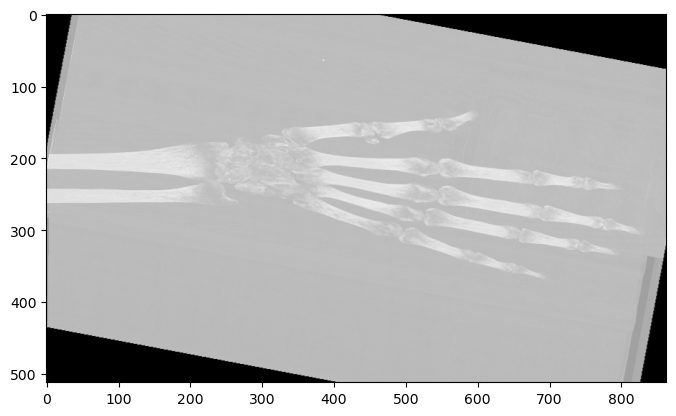

In [21]:
# Отображение изображения
image = tifffile.imread('05_projection_xrr542.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.2 Определениt координаты СРЕДИННОГО сечения искомого массива</h4>

In [22]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection_xrr542.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (200, 203)


<h4 style="color:Navy;">7.3 Изображение с ценой деления 10 для уточнения размера интервала третьего измерения искомого массива</h4>

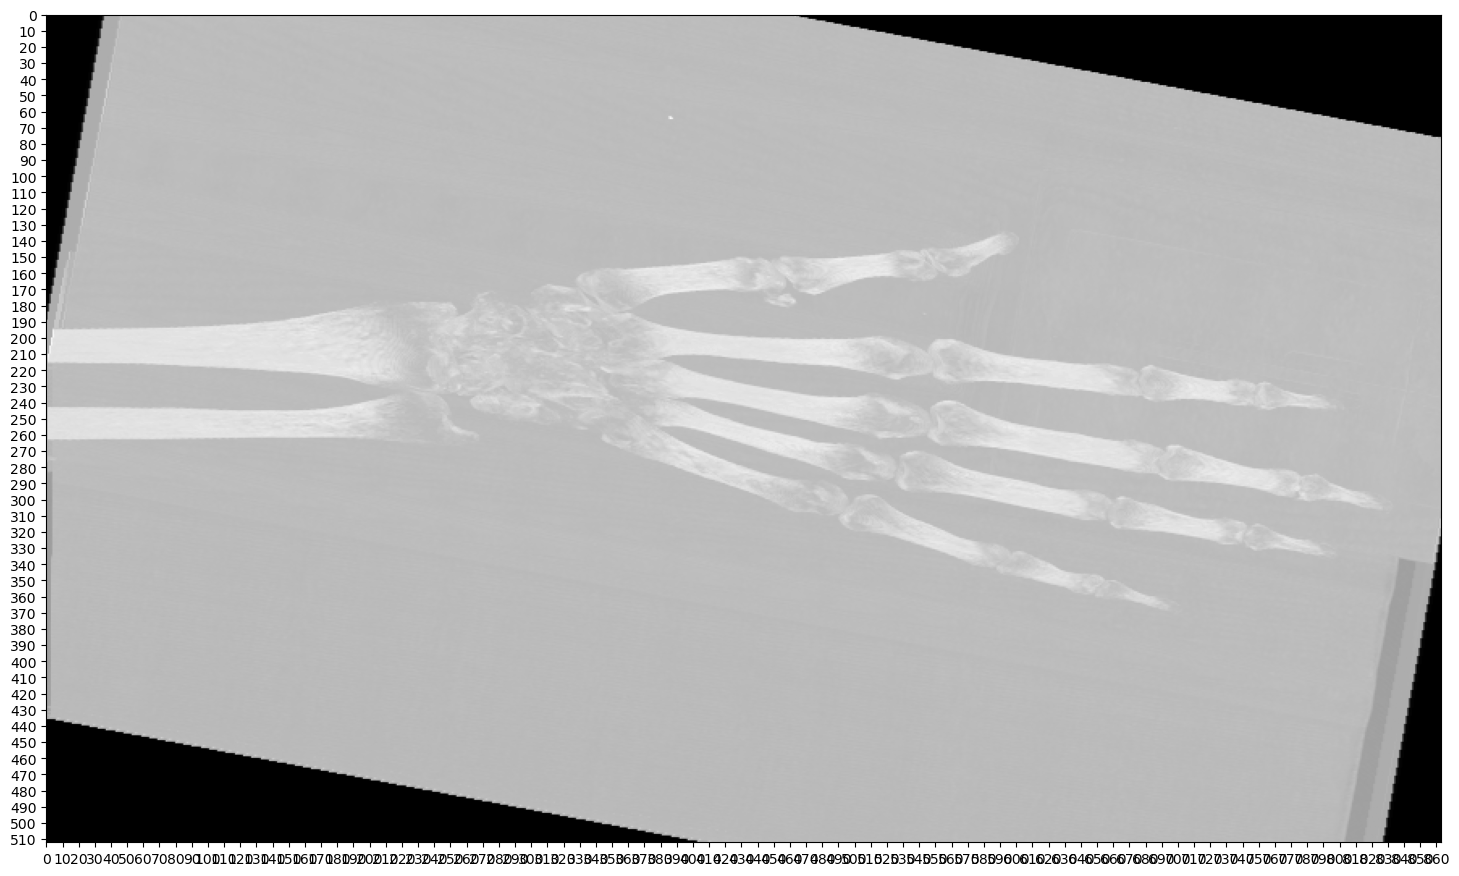

In [23]:
gray_image = mpimg.imread('05_projection_xrr542.tiff')

# Создание фигуры и осей
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(18, 12))  # Увеличенный размер холста
# Отображение изображения
ax.imshow(gray_image, cmap='gray', extent=[0, gray_image.shape[1], gray_image.shape[0], 0])

# Настройка тиков по осям x и y с шагом 20
ax.set_xticks(np.arange(0, gray_image.shape[1], 10))
ax.set_yticks(np.arange(0, gray_image.shape[0], 10))

# Показ графика
plt.show()

<h4 style="color:Navy;">7.4 Транспонирование twice_rotated_volume542 в нужную форму для получения искомых массива сечений</h4>

In [24]:
vol = np.transpose(twice_rotated_volume542, (1, 2, 0))
vol.shape

(512, 863, 512)

<h4 style="color:Navy;">7.5 Выбранный размер ОБЪЁМНОГО массива сечений кости</h4>

In [25]:
pict = vol[200:212]
pict.shape

(12, 863, 512)

<h4 style="color:Navy;">7.6 Преобразование массива к размерности (974, 512, 12) в соответствии с размерностью изображения</h4>

In [26]:
# Преобразование массива к размерности (863, 512, 10)
pict_12channels = np.transpose(pict, (2, 1, 0))

print(f"Исходный массив: {pict.shape}")
print(f"Преобразованный массив: {pict_12channels.shape}")

Исходный массив: (12, 863, 512)
Преобразованный массив: (512, 863, 12)


<h4 style="color:Navy;">7.7 Преобразование 12-канального "изображения" к 1-канальному</h4>

In [27]:
# Преобразование массива в (512, 863, 1)
pict_averaged12 = np.mean(pict_12channels, axis=2, keepdims=True)# axis=2 == среднее по третьей оси, keepdims=True сохраняет третью ось с размерностью 1 
# Зеркальное отражение изображения слева направо
flipped_image12 = np.flip(pict_averaged12, axis=1)
flipped_image12.shape

(512, 863, 1)

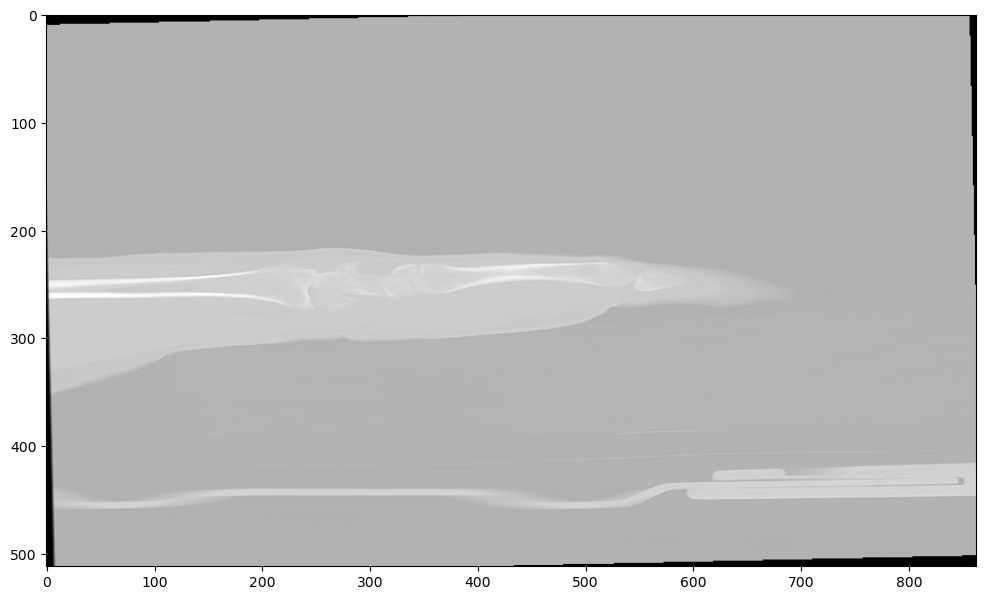

In [28]:
# Сохранение массива в TIFF-файл
tifffile.imwrite('06_from_vol_12_1_xrr542.tiff', flipped_image12)
# Отображение изображения
image = tifffile.imread('06_from_vol_12_1_xrr542.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.8 Преобразование одноканального трёхмерного изображения в двумерное</h4>

In [29]:
image = tifffile.imread('06_from_vol_12_1_xrr542.tiff')

image_array = np.array(image) # Преобразование в массив numpy (если нужно)
if image_array.ndim == 3 and image_array.shape[2] == 1: # Убедиться, что это одноканальное изображение
    gray_image = image_array[:, :, 0]  # Удаление последнего измерения

    # Преобразование обратно в изображение
    result_image = Image.fromarray(gray_image.astype(np.uint16))
    result_image.save('07_one_chan_from_vol_1_xrr542.tiff')

In [30]:
print(gray_image.shape)
print(gray_image.min())
print(gray_image.max())

(512, 863)
0.0
10321.083333333334


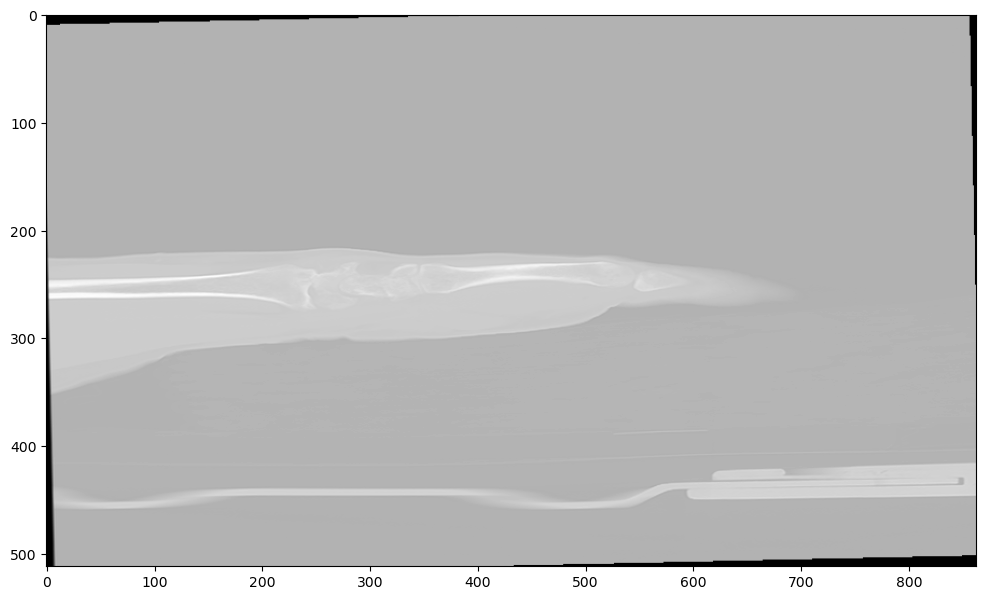

In [31]:
image = tifffile.imread('07_one_chan_from_vol_1_xrr542.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.9 Обрезка изображения по краям (на 30 пикселей) для быстрого получения контрастного изображения</h4>

In [32]:
image = Image.open('07_one_chan_from_vol_1_xrr542.tiff')
# размеры для обрезки
left = 25
top = 25
right = 25
bottom = 25
cropped_image = image.crop((left, top, image.width - right, image.height - bottom))
cropped_image.save('08_cropped_one_chan_from_vol_1_xrr542.tiff')

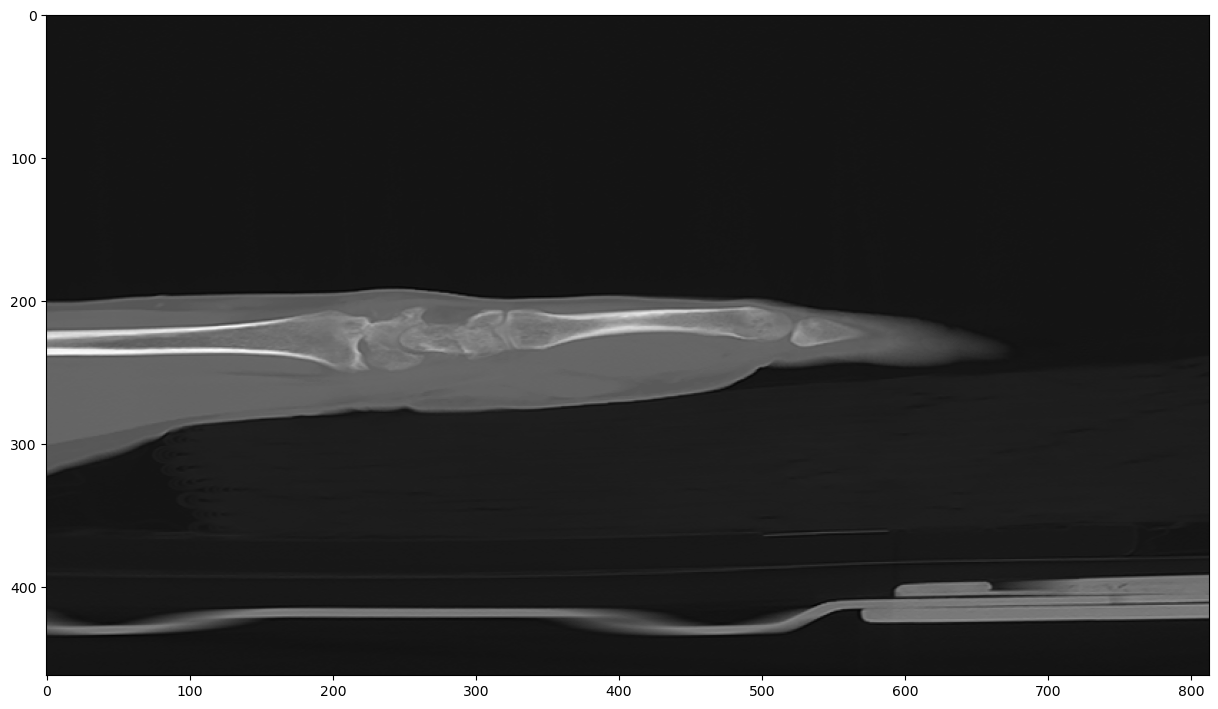

In [33]:
image = tifffile.imread('08_cropped_one_chan_from_vol_1_xrr542.tiff')
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.10 Вырезка изображения</h4>

In [34]:
matplotlib.use('TkAgg')  # Используйте TkAgg backend
plt.figure(figsize=(15, 15))

                
def crop_image(image, coords):
    cropped_image = image.crop(coords)
    return cropped_image

def get_coords(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    coords = plt.ginput(4)
    plt.close()
    return coords

image_path = '08_cropped_one_chan_from_vol_1_xrr542.tiff'
image = tifffile.imread(image_path)
#enhancer = ImageEnhance.Contrast(image) # Создание объекта для улучшения контрастности
#enhanced_image = enhancer.enhance(1.0) # Увеличение контрастности в 2 раза
coords = get_coords(image_path)

x_coordinates = sorted([int(coord[0]) for coord in coords])
y_coordinates = sorted([int(coord[1]) for coord in coords])
    
x1, y1 = x_coordinates[0], y_coordinates[0]
x2, y2 = x_coordinates[3], y_coordinates[3]
        
plt.figure(figsize=(20, 20))
image = Image.open(image_path)
cropped_image = crop_image(image, (x1, y1, x2, y2))
               
#output_path = os.path.join(output_folder, file_name)
cropped_image.save('09_ready542.tiff')

<Figure size 2000x2000 with 0 Axes>

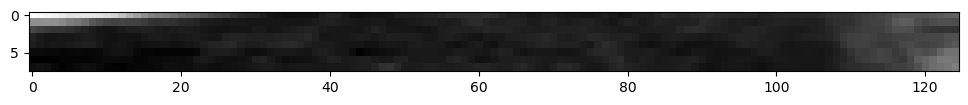

In [35]:
%matplotlib inline
image = tifffile.imread('09_ready542.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.11 Обрезка в размер (100 пикселей) для корректности сравнения различных образцов</h4>

In [36]:
# Загрузка изображения
imageqq = tifffile.imread('09_ready542.tiff')
# Преобразование в массив numpy (если нужно)
image_arrayqq = np.array(imageqq)
image_arrayqq.shape

(8, 125)

In [37]:
image_arrayqq.shape[1]

125

In [38]:
image = Image.open('09_ready542.tiff')
# размеры для обрезки
left = image_arrayqq.shape[1] - 100
top = 0
right = 0
bottom = 0
cropped_image = image.crop((left, top, image.width - right, image.height - bottom))
cropped_image.save('10_ready542_cropped.tiff')

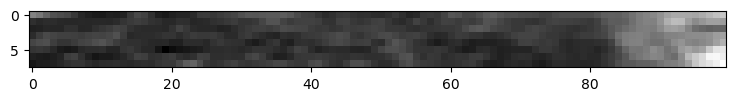

In [39]:
%matplotlib inline
image = tifffile.imread('10_ready542_cropped.tiff')
plt.figure(figsize=(9, 9))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.12 Определение плотности по средневзвешеному значению среднеобъёмных пикселей</h4>

#### патология

In [40]:
# Загрузка изображения в градациях серого
image = cv2.imread('10_ready542_cropped.tiff', cv2.IMREAD_GRAYSCALE)

# Пример весов (например, можно задать каждому пикселю одинаковый вес)
height, width = image.shape
weights = np.ones((height, width))

# Обратим внимание: изображение и веса должны быть выровнены линейно
linear_image = image.flatten()
linear_weights = weights.flatten()

# Вычисление средневзвешенного значения всех пикселей
weighted_mean3 = np.average(linear_image, weights=linear_weights)

print(f'Средневзвешенное значение всех пикселей: {weighted_mean3}')

Средневзвешенное значение всех пикселей: 32.255


#### норма моно

In [36]:
# Загрузка изображения в градациях серого
image = cv2.imread('09_rectangle_MONO_xrr152_finish.tiff', cv2.IMREAD_GRAYSCALE)

# Пример весов (например, можно задать каждому пикселю одинаковый вес)
height, width = image.shape
weights = np.ones((height, width))

# Обратим внимание: изображение и веса должны быть выровнены линейно
linear_image = image.flatten()
linear_weights = weights.flatten()

# Вычисление средневзвешенного значения всех пикселей
weighted_mean2 = np.average(linear_image, weights=linear_weights)

print(f'Средневзвешенное значение всех пикселей: {weighted_mean2}')

Средневзвешенное значение всех пикселей: 32.101


#### норма "стерео"

In [51]:
# Загрузка изображения в градациях серого
image = cv2.imread('14_vol_20_1_xrr152_ready.tiff', cv2.IMREAD_GRAYSCALE)

# Пример весов (например, можно задать каждому пикселю одинаковый вес)
height, width = image.shape
weights = np.ones((height, width))

# Обратим внимание: изображение и веса должны быть выровнены линейно
linear_image = image.flatten()
linear_weights = weights.flatten()

# Вычисление средневзвешенного значения всех пикселей
weighted_mean1 = np.average(linear_image, weights=linear_weights)

print(f'Средневзвешенное значение всех пикселей: {weighted_mean1}')

Средневзвешенное значение всех пикселей: 32.24727272727273


<h2 style="color:Navy;">9. Раскрытие суставных щелей</h2>

<h4 style="color:Navy;">9.1 Ветикальное сечение проекции "projection_yrr" Side Projection (Y axis)</h4>

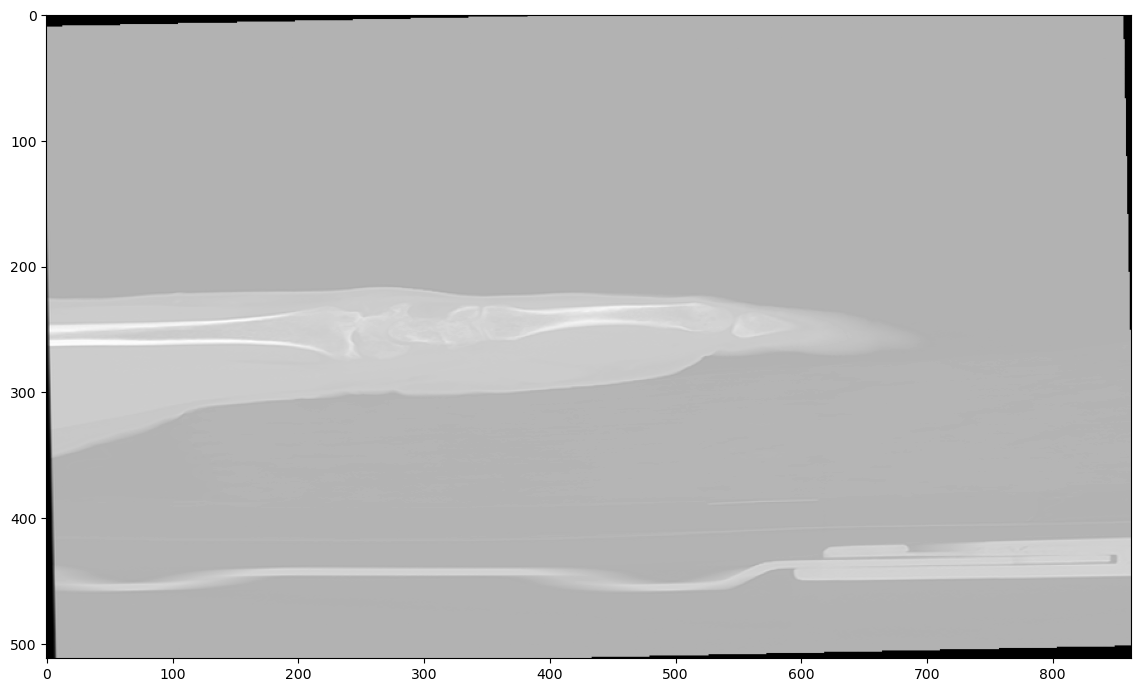

In [41]:
image = tifffile.imread('07_one_chan_from_vol_1_xrr542.tiff')
plt.figure(figsize=(14, 14))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

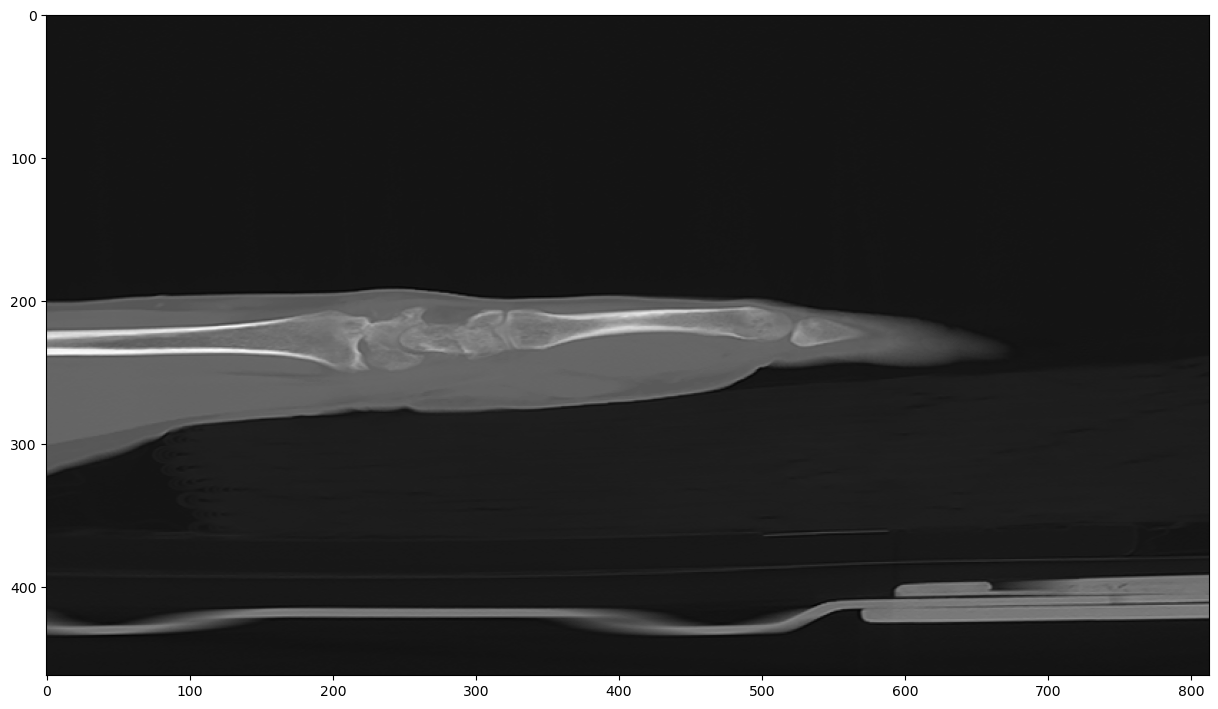

In [42]:
image = tifffile.imread('08_cropped_one_chan_from_vol_1_xrr542.tiff')
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">9.2 Определение на ветикальном сечении проекции "projection_yrr" Side Projection координату последующего сечения Z плоскостью</h4>

In [43]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('07_one_chan_from_vol_1_xrr542.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=30, contrast=500)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (231, 255)


<h4 style="color:Navy;">9.3 Сечение массива второго поворота "twice_rotated_volume152" плоскостью на высоте 255</h4>

In [44]:
twice_rotated_volume542.shape

(512, 512, 863)

In [45]:
voll = np.transpose(twice_rotated_volume542, (0, 1, 2))
voll.shape

(512, 512, 863)

In [46]:
pictt4 = twice_rotated_volume542[247]
# Зеркальное отражение изображения слева направо
#flipped_pictt1 = np.flip(pictt1, axis=1)
flipped_pictt44 = np.transpose(pictt4, (1, 0))

In [47]:
pictt5 = twice_rotated_volume542[251]
# Зеркальное отражение изображения слева направо
#flipped_pictt2 = np.flip(pictt2, axis=1)
flipped_pictt55 = np.transpose(pictt5, (1, 0))

In [48]:
pictt6 = twice_rotated_volume542[255]
# Зеркальное отражение изображения слева направо
#flipped_pictt3 = np.flip(pictt3, axis=1)
flipped_pictt66 = np.transpose(pictt6, (1, 0))

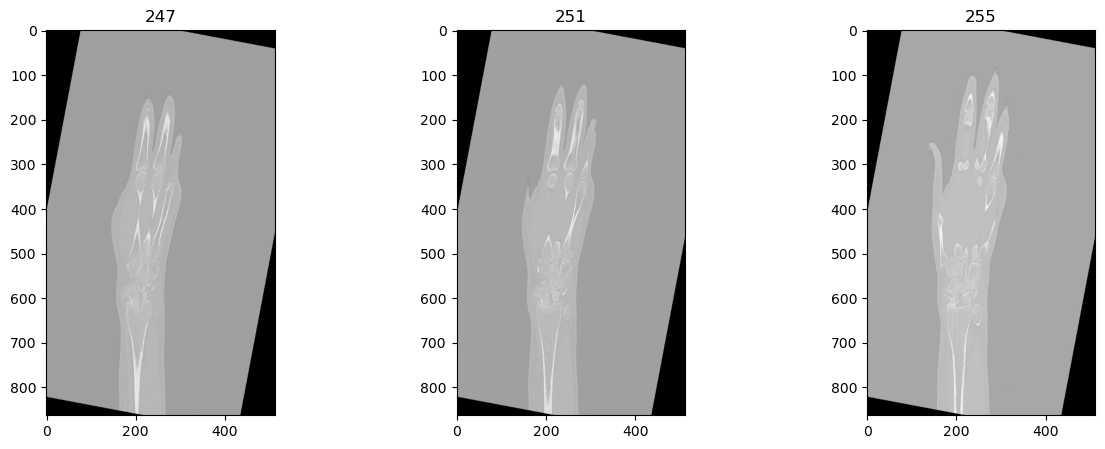

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt44, cmap='gray')
axs[0].set_title('247')

axs[1].imshow(flipped_pictt55, cmap='gray')
axs[1].set_title('251')

axs[2].imshow(flipped_pictt66, cmap='gray')
axs[2].set_title('255')

plt.show()

<h4 style="color:DarkSlateGray;">9.4 Обрезка изображения для черно-белого изображения</h4>

In [50]:
tifffile.imwrite('15_247_542.tiff', flipped_pictt44) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_251_542.tiff', flipped_pictt55) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_255_542.tiff', flipped_pictt66) # Сохранение массива в TIFF-файл

In [51]:
image = Image.open('15_247_542.tiff')

# размеры для обрезки
left = 100
top = 400
right = 200
bottom = 200

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_247_542_bw.tiff')

#### 247

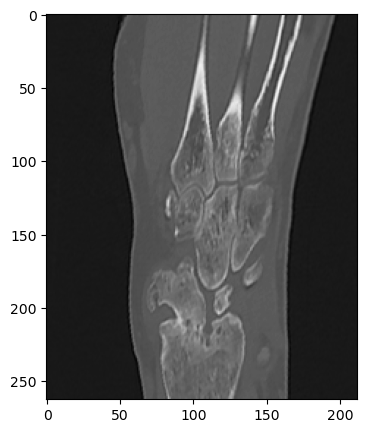

In [52]:
%matplotlib inline

gray_image152 = Image.open('16_247_542_bw.tiff')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [53]:
image = Image.open('15_251_542.tiff')

# размеры для обрезки
left = 100
top = 400
right = 200
bottom = 200

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_251_542_bw.tiff')

#### 251

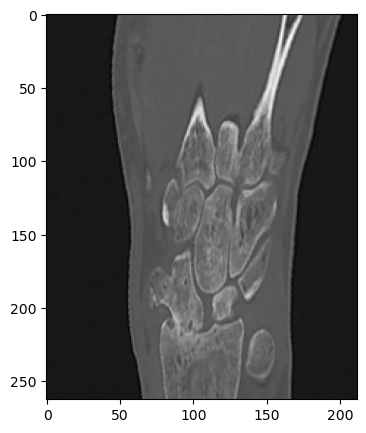

In [54]:
%matplotlib inline
#gray_image152 = mpimg.imread('152_for_line.png')
gray_image152 = Image.open('16_251_542_bw.tiff')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [56]:
image = Image.open('15_255_542.tiff')

# размеры для обрезки
left = 100
top = 400
right = 200
bottom = 200

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_255_542_bw.tiff')

#### 255

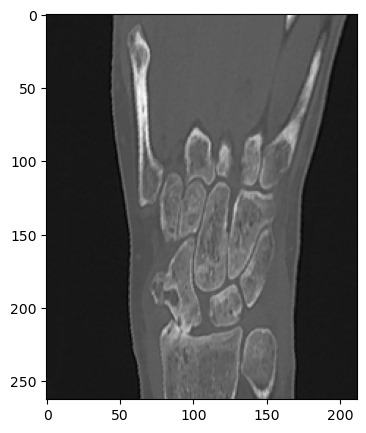

In [57]:
%matplotlib inline
#gray_image152 = mpimg.imread('152_for_line.png')
gray_image152 = Image.open('16_255_542_bw.tiff')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [58]:
pictt = twice_rotated_volume542[259]
# Зеркальное отражение изображения слева направо
flipped_pictt = np.flip(pictt, axis=1)
flipped_pictt.shape

(512, 863)

In [59]:
import tifffile
# Сохранение массива в TIFF-файл
tifffile.imwrite('13_z_542.tiff', flipped_pictt)

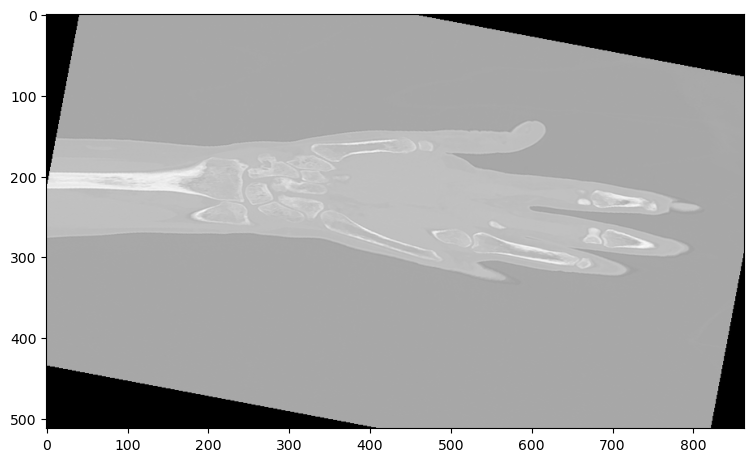

In [60]:
# Отображение изображения
image = tifffile.imread('13_z_542.tiff')
plt.figure(figsize=(9, 9))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

In [61]:
imagett = tifffile.imread('13_z_542.tiff')

In [62]:
print(imagett[100,5])
print(imagett[203,5])
print(imagett[350,5])

0
9667
7186


In [63]:
# ИНАЧЕ НЕ ВЫЧИТАЕТСЯ НОРМАЛЬНО
imagett_int32 = imagett.astype(np.int32)

In [64]:
# Выполнение вычитания
subtract_value = 7203 # Значение для вычитания
imagenn = imagett_int32 - subtract_value

In [65]:
# Замена элементов со значением -7214 на нули
imagenn[imagenn < 0] = 0

In [66]:
print(imagenn.max())
print(imagenn.min())
print(imagenn.mean())

3773
0
254.10546422363848


In [67]:
# Нормализуем изображение
image_norm = (imagenn - imagenn.min()) / (imagenn.max() - imagenn.min())
image_norm = (image_norm * 255).astype(np.uint8)

# Сохраняем нормализованное изображение в формате PNG
plt.imsave("14_z_542.png", image_norm)

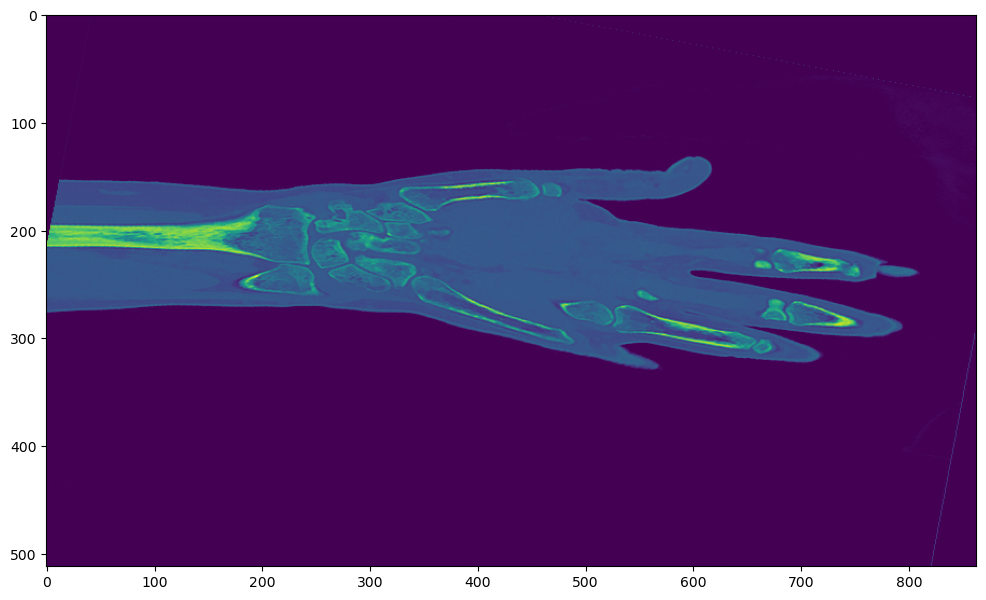

In [68]:
%matplotlib inline
gray_image152 = mpimg.imread('14_z_542.png')
plt.figure(figsize=(12, 12)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">9.4 Обрезка изображения и поворот</h4>

In [78]:
image = Image.open('14_z_542.png')

# размеры для обрезки
left = 175
top = 100
right = 475
bottom = 200

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('17_zz_542.png')

In [79]:
input_path = '17_zz_542.png'
# Путь для сохранения преобразованного изображения
output_path = '18_zz_542.png'

# Загрузка изображения
image = Image.open(input_path)

# Поворот изображения на 90 градусов против часовой стрелки
rotated_image = image.rotate(90, expand=True)

# Сохранение преобразованного изображения
rotated_image.save(output_path)

print(f"Image saved to {output_path}")

Image saved to 18_zz_542.png


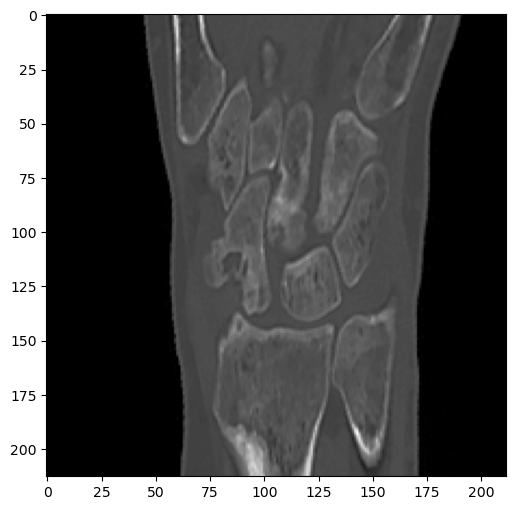

In [81]:
%matplotlib inline
#gray_image152 = mpimg.imread('152_for_line.png')
gray_image152 = Image.open('18_zz_542.png')

# Преобразование изображения в черно-белый формат
gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(6, 6)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()